processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 3s 9ms/step - loss: 536.7124 - mean_absolute_error: 22.4706 - val_loss: 562.2408 - val_mean_absolute_error: 23.2224
Epoch 2/500
303/303 [==============================] - 0s 295us/step - loss: 518.2286 - mean_absolute_error: 22.2957 - val_loss: 571.2614 - val_mean_absolute_error: 22.9947
Epoch 3/500
303/303 [==============================] - 0s 290us/step - loss: 510.5046 - mean_absolute_error: 22.1488 - val_loss: 511.1949 - val_mean_absolute_error: 22.2669
Epoch 4/500
303/303 [==============================] - 0s 301us/step - loss: 499.1766 - mean_absolute_error: 21.9955 - val_loss: 598.2691 - val_mean_absolute_error: 24.0148
Epoch 5/500
303/303 [==============================] - 0s 297us/step - loss: 493.5378 - mean_absolute_error: 21.8364 - val_loss: 570.8058 - val_mean_absolute_error: 23.5241
Epoch 6/500
303/303 [==============================] - 0s 304us/step - 

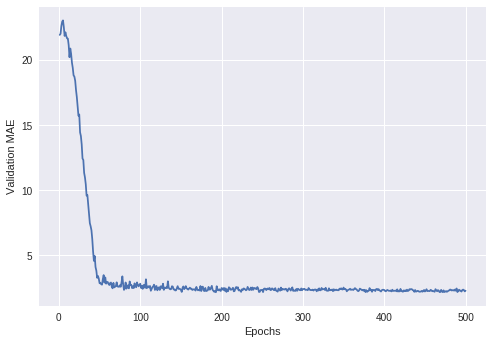

In [10]:
from keras.datasets import boston_housing
from keras import models
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)
def weight_variable(shape):
    return K.truncated_normal(shape, stddev=0.01)

'''
データの設定
'''
# data:レビューのリスト(単語のシーケンスをエンコード済み)
# labels: 0で「否定的」、1で「肯定的」
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()   # train_data.shape:(404, 13), test_data.shape:(102, 13)

# データの正規化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

def builed_model():
    model = models.Sequential()
    model.add(Dense(64, activation= "relu", input_dim= train_data.shape[1], kernel_initializer=weight_variable))     # input_shape=(784,) = input_dim=784
    model.add(BatchNormalization())
    model.add(Dense(64, activation= "relu", kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(optimizer= "rmsprop", loss= "mse", metrics= ["mae"])
    return model

'''
K分割交差検証
'''
batch_size = 30
k = 4
num_val_samples = len(train_data) // k      # train_dataをk分割
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print("processing fold #", i)
    # 検証データの準備:フォールドiのデータ
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    # 訓練データの検証:残りのフォールドのデータ
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis= 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis= 0)
    # kerasモデル(コンパイル済み)を構築
    model = builed_model()

    '''
    学習
    '''
    history = model.fit(partial_train_data, partial_train_targets, epochs= num_epochs, batch_size= batch_size, validation_data=(val_data, val_targets), verbose=1)

    # val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    # all_scores.append(val_mae)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

'''
評価
'''
# print(all_scores)
# print(np.mean(all_scores))
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()






# val_size = 1000
#
# x_val = x_train[:val_size]
# partial_x_train = x_train[val_size:]
# y_val = y_train[:val_size]
# partial_y_train = y_train[val_size:]
#
# print(len(x_train))
# print(len(x_val))
# print(len(partial_x_train))
#
#
# '''
# モデルの構築
# '''
# def weight_variable(shape):
#     return K.truncated_normal(shape, stddev=0.01)
# n_in = len(x_train)
# n_out = 46
# n_hiddens = [64]
# # p_keep = 0.4
# early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)
#
# model = models.Sequential()
# model.add(Dense(64, kernel_initializer= weight_variable, activation='relu'))
# model.add(BatchNormalization())
# for i, input_shape in enumerate(([n_in]+n_hiddens)[:-1]):
#     model.add(Dense(n_hiddens[i], kernel_initializer=weight_variable, activation="relu"))
#     model.add(BatchNormalization())
# #     model.add(Dropout(p_keep))
# model.add(Dense(n_out, kernel_initializer= weight_variable, activation= "softmax"))
#
# model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])
#
# '''
# モデル学習
# '''
# history = model.fit(partial_x_train,partial_y_train,epochs=100,batch_size=512,validation_data=(x_val, y_val), callbacks= [early_stopping])
#
# '''
# 予測精度の評価
# '''
# history_dict = history.history
# loss_values = history_dict["loss"]
# val_loss_values = history_dict["val_loss"]
# acc_values = history_dict["acc"]
# val_acc_values = history_dict["val_acc"]
#
# epochs = range(1, len(loss_values) + 1)
# plt.rc('font', family='serif')
# fig = plt.figure()
# ax_loss = fig.add_subplot(111)
# g1 = ax_loss.plot(epochs, loss_values, label='loss', color='gray')
# g2 = ax_loss.plot(epochs, val_loss_values, label= "val_loss", color="blue")
# ax_acc = ax_loss.twinx()
# g3 = ax_acc.plot(epochs, acc_values, label='acc', color='pink')
# g4 = ax_acc.plot(epochs, val_acc_values, label='val_acc', color='red')
# plt.title("loss & acc")
#
# h1, l1 = ax_loss.get_legend_handles_labels()
# h2, l2 = ax_acc.get_legend_handles_labels()
# ax_loss.legend(h1+h2, l1+l2, loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=4)
#
# ax_loss.set_xlabel("Epochs")
# ax_loss.set_ylabel("loss")
# ax_loss.grid(True)
# ax_acc.set_ylabel("acc")
# plt.show()
